# Computation of the empirical probability content of a depth contour

Import packages

In [49]:
import mallows_kendall as mk
import numpy as np
import itertools as it
import scipy as sp
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import math

### The C++ load and verification part

Compile C++ codes if necessary

In [50]:
# Compilation
#import os
#os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -fPIC  -Wall -g -O2  -c rankDepth.cpp -o rankDepth.o')
#os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -o rankDepth.so rankDepth.o')
# Restart the kernel after this line

Import (and test) the dynamic library

In [51]:
# Import and Test 1
from ctypes import *
cdll.LoadLibrary('rankDepth.so')
libc = CDLL('rankDepth.so')
libc.testFunc()

43

In [52]:
# Test 2
val = np.array([5.1])
obj = np.array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1])
n = 10
outp = np.array([1.1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
res2 = libc.testFuncCmp(c_void_p(val.ctypes.data),
                       c_void_p(obj.ctypes.data),
                       c_int(n),
                       c_void_p(outp.ctypes.data))
print(res2)
print(outp)

0
[  1.1   0.    0.    0.    0.    0.    0.    0.    0.  142. ]


Depth-calculating Python function

In [53]:
def qrdepth(objects, data):
    '''
    The function to calculate the qr-depths
    '''
    depths = np.zeros(objects.shape[0])
    for i in range(objects.shape[0]):
        for j in range(data.shape[0]):
            depths[i] += (mk.max_dist(objects.shape[1]) - mk.kendall_tau(objects[i,:], data[j,:])) / mk.max_dist(objects.shape[1])
        depths[i] /= data.shape[0]
    return depths

### Define model constants

In [107]:
modelShorts = ["model1", "model2"]

### Model 1: Obviously simple mixture of two Mallows-Kendalls

In [110]:
np.random.seed(1)
iModel = 0
n = 10
m1 = 35
m2 = 215
m = m1 + m2
# Define centers
cons1 = np.random.permutation(n) # center of normal observations
cons2 = np.array(cons1) # center of anomalies
tmpWhere1 = np.where(cons1 == 0)
tmpWhere2 = np.where(cons1 == 8)
cons2[tmpWhere1] = 8
cons2[tmpWhere2] = 0
print(mk.kendall_tau(cons2, cons1)) # Distance between centers
# Generate the data
sSample1 = mk.sampling_mm(m = m1, n = n, theta = 0.5, phi = None, s0 = cons1)
sSample2 = mk.sampling_mm(m = m2, n = n, theta = 2.5, phi = None, s0 = cons2)
# Join the data
empDist = np.concatenate((np.array(sSample1, dtype = c_int), 
                         np.array(sSample2, dtype = c_int)))

15


### Model 2: A more difficult case

In [121]:
np.random.seed(1)
iModel = 1
n = 10
m1 = 125
m2 = 125
m = m1 + m2
# Define centers
cons1 = np.random.permutation(n) # center of normal observations
cons2 = np.array(cons1) # center of anomalies
tmpWhere1 = np.where(cons1 == 0)
tmpWhere2 = np.where(cons1 == 6)
cons2[tmpWhere1] = 6
cons2[tmpWhere2] = 0
print(mk.kendall_tau(cons2, cons1)) # Distance between centers
# Generate the data
sSample1 = mk.sampling_mm(m = m1, n = n, theta = 0.25, phi = None, s0 = cons1)
sSample2 = mk.sampling_mm(m = m2, n = n, theta = 2.5, phi = None, s0 = cons2)
# Join the data
empDist = np.concatenate((np.array(sSample1, dtype = c_int), 
                         np.array(sSample2, dtype = c_int)))

11


Shuffle

In [122]:
rndIds = np.array(list(range(m)))
random.shuffle(rndIds)
isFirst = np.where(rndIds < m1)
isSecond = np.where(rndIds > m1)
empDist = empDist[rndIds,:]

### Plot the depth visualization

Calculate depths of all observations w.r.t. the same sample

In [123]:
depths = qrdepth(empDist, empDist)
print(depths[1:10])
print(depths[m1:m1 + 10])
print(rndIds)

[0.43404444 0.58764444 0.76044444 0.74746667 0.45377778 0.38746667
 0.76115556 0.596      0.58      ]
[0.58853333 0.57928889 0.52417778 0.47493333 0.77004444 0.77093333
 0.78017778 0.75991111 0.5976     0.75884444]
[ 45 117  68 140 166  73  92 158  81  23 244  51  42 176 138 107 186 103
 197  88 142 122   1 167 212  35 104 123 119 115   4 113  24 246  21 184
  36 220  89 112 139  11   5 237   8 102  64  31 100  87 116 228 190 125
  63  38 108 132  91 202 192 183   6 128  57 144  58  80 193 151  95 207
 181 231 198  22 126  43  39  85 160 195  10 243  26 101 120 209 203  44
  94 172  67 133 143 164 136 216 154  54  50 221  32 179  34 225 215 141
  74  61 159 241 149 182  53  47  29 110  15 222  97   7 205 118 187  76
  52 105  49 233 223 157 235  98 189 188 156 161 178 171 199  17  41  28
 214 180  25 211  20 173 242 153  46 174  19 165 109 155  99  12  14  86
 239  16 247 148  33 111 249  75 204 146 152 238  70  56  90 163 137 206
  48 234 210  84 150  27 219 130 145 191   9  78 129  6

Visualize the detphs

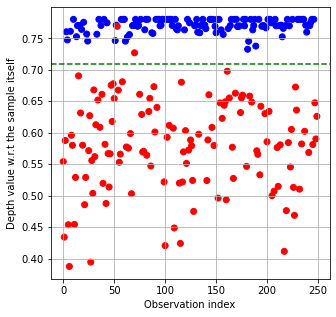

In [132]:
plt.close("all")
plt.figure(1, figsize=(5, 5))
if iModel == 1:
    curColors = np.repeat("r", m)
    curColors[isSecond] = "b"
if iModel == 0:
    plt.scatter(range(m), depths, c = np.concatenate((np.repeat("r", m1), np.repeat("b", m2))))
if iModel == 1:
    plt.scatter(range(m), depths, c = curColors)
plt.xlabel("Observation index")
plt.ylabel("Depth value w.r.t the sample itself")
if iModel == 0:
    plt.axvline(x = m1 + 0.5, color = 'green')
if iModel == 1:
    plt.axhline(y = 0.71, color = 'green', ls='--')
plt.grid()
plt.savefig("pic-anomplot-n10-" + modelShorts[iModel] + ".pdf")

Pot the DD-plot

In [128]:
if iModel == 0:
    sSampleOur1 = sSample1
    sSampleOur2 = sSample2
if iModel == 1:
    sSampleOur1 = empDist[depths < 0.71,:]
    sSampleOur2 = empDist[depths >= 0.71,:]
depths1 = np.transpose(np.array([qrdepth(sSampleOur1, sSampleOur1), qrdepth(sSampleOur1, sSampleOur2)]))
#print(depths1)
depths2 = np.transpose(np.array([qrdepth(sSampleOur2, sSampleOur1), qrdepth(sSampleOur2, sSampleOur2)]))
#print(depths2)

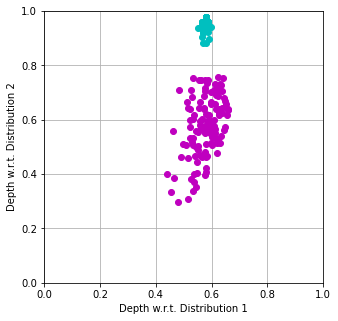

In [129]:
plt.close("all")
plt.figure(1, figsize=(5, 5))
plt.plot(depths1[:,0], depths1[:,1], 'mo')
plt.plot(depths2[:,0], depths2[:,1], 'co')
plt.xlabel("Depth w.r.t. Distribution 1")
plt.ylabel("Depth w.r.t. Distribution 2")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid()
plt.savefig("pic-anomddplot-n10-" + modelShorts[iModel] + ".pdf")